In [1]:
import pickle
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from gensim.corpora import Dictionary
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime

import re

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Carregar dados
with open('df_pedidos_baixados_2020_a_2023.pkl', 'rb') as file:
    dados = pickle.load(file)
dados = dados[dados.Ano==2022]

In [4]:
dados.shape

(68177, 8)

In [5]:
percentual_de_recorte = 75  # Ajustar aqui para recortar
recorte_amostral = dados.query(f'PercentualAcumulado_2020_2023 <= {percentual_de_recorte}').copy()
print(recorte_amostral.OrgaoDestinatario.unique().shape)

percentual_limite = 70 # Ajustar aqui para definir os "Outros" (percentual_de_recorte-percentual_limite)
recorte_amostral['Orgao_alvo'] = recorte_amostral.apply(lambda row: row['OrgaoDestinatario'] 
                               if row['PercentualAcumulado_2020_2023'] <= percentual_limite else 'Outros', axis=1)
recorte_amostral = recorte_amostral[['Orgao_alvo', 'Mês', 'Dia da Semana', 'DetalhamentoSolicitacao']]
print(recorte_amostral.shape)
print(recorte_amostral.Orgao_alvo.unique().shape)

(61,)
(52178, 4)
(47,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    recorte_amostral[['Orgao_alvo', 'Mês', 'Dia da Semana', 'DetalhamentoSolicitacao']], recorte_amostral['Orgao_alvo'], test_size=0.2, random_state=42)

In [7]:
X_train['DetalhamentoSolicitacao'].iloc[0]

'Solicito as seguintes informações:    * O Ministério da Mulher orienta que crianças não sejam vacinadas nos casos recomendados pelas autoridades sanitárias, como ANVISA?  * Qual é o protocolo que o Ministério da Mulher adota como oficial para as crianças com relação a Covid-19?'

In [8]:
X_train['DetalhamentoSolicitacaoList'] = X_train['DetalhamentoSolicitacao'].apply(lambda txt: re.findall(r"\w+|[^\w\s]", txt.lower(), re.UNICODE))
X_test['DetalhamentoSolicitacaoList'] = X_test['DetalhamentoSolicitacao'].apply(lambda txt: re.findall(r"\w+|[^\w\s]", txt.lower(), re.UNICODE))


In [9]:
def return_vector_doc(text, model):
    v = np.zeros(model.vector_size)
    count = 0
    for t in text:
        if t in model.wv:
            count += 1
            v += model.wv[t]

    if count != 0:
        r = v/count
    else:
        r = np.ones(model.vector_size)
    
    return v/count


In [10]:
# Definindo conjunto de dados personalizado para PyTorch
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        

In [11]:
# Definindo o modelo de rede neural
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNetwork, self).__init__()
        tamanho_entrada = input_shape
        torch.manual_seed(42)
        self.fc1 = nn.Linear(tamanho_entrada, 1024)  
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, output_shape)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Passando pela primeira camada totalmente conectada
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
       # x = self.relu(self.fc3(x))
       # x = self.dropout(x)
        x = self.fc4(x)
        return self.logsoftmax(x)

In [18]:
# Função para avaliação do modelo
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            #outputs = model(inputs)
            #_, predicted = torch.max(outputs.data, 1)

            #outputs = model(inputs).cpu()
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim=1)

            total += labels.size(0)
            correct += (outputs==labels).sum().item()
            y_pred.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    accuracy = correct / total
    return accuracy, y_true, y_pred
    
# Função para treinamento do modelo
def train(model, train_loader, test_loader, criterion, optimizer, epochs=10, use_best_model=False, early_stop=False):
    score=0
    if use_best_model:
        best_score = 0.01
        best_epoch = 0
        best_model_wts = copy.deepcopy(model.state_dict())
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            #loss = criterion(outputs, torch.max(labels, 1)[1])
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        if use_best_model or early_stop:
            accuracy, y_true, y_pred = evaluate_model(model, test_loader)
            precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
            recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
            f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
            score_anterior = score
            score = f1
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}", 
                  f"Acc: {accuracy:,.5f}", 
                  f"Prc: {precision:,.5f}", 
                  f"Rcl: {recall:,.5f}", 
                  f"F1: {f1:,.5f}")
            #print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}, Score: {score:,.5f}")
        else:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):,.5f}")
        if use_best_model:
            if score > best_score:
                best_epoch = epoch+1
                best_score = score
                best_model_wts = copy.deepcopy(model.state_dict())
        if early_stop and score - score_anterior <= -0.01:
            print(f"Métrica parou de melhorar. Interrompendo o treinamento...")
            break
    if use_best_model and best_epoch!=epoch+1:
        model.load_state_dict(best_model_wts)
        print(f"Carregando modelo da melhor epoca - {best_epoch}")
    print(f"Fim.")

In [ ]:
# 8672
# 16 e 6
# 47 grupos

In [21]:
model_w2v = Word2Vec(sentences=list(X_train['DetalhamentoSolicitacaoList']), vector_size=9000, window=5, min_count=1, workers=4, epochs=300)


In [22]:
X_train['w2v'] = X_train['DetalhamentoSolicitacaoList'].apply(lambda txt: return_vector_doc(txt, model_w2v))
X_test['w2v'] = X_test['DetalhamentoSolicitacaoList'].apply(lambda txt: return_vector_doc(txt, model_w2v))


/tmp/ipykernel_2794/1654401860.py:14: RuntimeWarning: invalid value encountered in divide
  return v/count


In [23]:
X_train_w2v = np.stack(X_train['w2v'].to_numpy())
X_test_w2v =  np.stack(X_test['w2v'].to_numpy())

# Codificação dos rótulos
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_train_encoded = torch.tensor(y_train_encoded, dtype=torch.long)
y_train_encoded = nn.functional.one_hot(y_train_encoded)  # Convertendo para one-hot encoding

y_test_encoded = label_encoder.transform(y_test)
y_test_encoded = torch.tensor(y_test_encoded, dtype=torch.long)

# Codificação dos parâmetros adicionais: mês e dia da semana
onehot_encoder = OneHotEncoder()
mes_dia_semana_encoded_train = onehot_encoder.fit_transform(X_train[['Mês', 'Dia da Semana']])
mes_dia_semana_encoded_test = onehot_encoder.transform(X_test[['Mês', 'Dia da Semana']])

X_tr = torch.tensor(np.concatenate((X_train_w2v, mes_dia_semana_encoded_train.toarray()), axis=1), dtype=torch.float32)
X_ts = torch.tensor(np.concatenate((X_test_w2v, mes_dia_semana_encoded_test.toarray()), axis=1), dtype=torch.float32)


In [24]:
# Criando DataLoader para conjuntos de treinamento e teste
train_dataset = CustomDataset(X_tr, y_train_encoded)
train_loader = DataLoader(train_dataset, batch_size=90, shuffle=True)
test_dataset = CustomDataset(X_ts, y_test_encoded)
test_loader = DataLoader(test_dataset, batch_size=90, shuffle=False)

In [25]:
# Inicializando o modelo
torch.cuda.empty_cache()
input_shape = X_tr.shape[1]
output_shape = y_train_encoded.shape[1]
model = NeuralNetwork(input_shape, output_shape).to(device) ####

# Definindo a função de perda e otimizador
criterion = nn.CrossEntropyLoss() #.to(device) ####
adam01 = optim.Adam(model.parameters(), lr=0.01)
adam005 = optim.Adam(model.parameters(), lr=0.005)
adam001 = optim.Adam(model.parameters(), lr=0.001)
adam0005 = optim.Adam(model.parameters(), lr=0.0005)
adam0001 = optim.Adam(model.parameters(), lr=0.0001)

sgd0005 = torch.optim.SGD(model.parameters(), lr=0.0005)
model

NeuralNetwork(
  (fc1): Linear(in_features=9019, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=47, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.05, inplace=False)
  (logsoftmax): LogSoftmax(dim=1)
)

In [26]:
# Treinamento do modelo
#train(model, train_loader, test_loader, criterion,  adam01, epochs=11, use_best_model=True, early_stop=True) #*
#train(model, train_loader, test_loader, criterion,  adam005, epochs=12, use_best_model=True, early_stop=True) #*
train(model, train_loader, test_loader, criterion,  adam0005, epochs=100, use_best_model=True, early_stop=False) #* 
#train(model, train_loader, test_loader, criterion,  adam0001, epochs=13, use_best_model=True, early_stop=True) #*

Epoch 1/100, Loss: 2.24946 Acc: 0.50613 Prc: 0.54772 Rcl: 0.50613 F1: 0.45110
Epoch 2/100, Loss: 1.60643 Acc: 0.57752 Prc: 0.63748 Rcl: 0.57752 F1: 0.56519
Epoch 3/100, Loss: 1.39807 Acc: 0.59831 Prc: 0.65434 Rcl: 0.59831 F1: 0.58064
Epoch 4/100, Loss: 1.25390 Acc: 0.62141 Prc: 0.64184 Rcl: 0.62141 F1: 0.60330
Epoch 5/100, Loss: 1.15509 Acc: 0.62236 Prc: 0.67772 Rcl: 0.62236 F1: 0.62249
Epoch 6/100, Loss: 1.06248 Acc: 0.64881 Prc: 0.66145 Rcl: 0.64881 F1: 0.63770
Epoch 7/100, Loss: 0.99442 Acc: 0.63425 Prc: 0.66540 Rcl: 0.63425 F1: 0.63506
Epoch 8/100, Loss: 0.92455 Acc: 0.64891 Prc: 0.67249 Rcl: 0.64891 F1: 0.64396
Epoch 9/100, Loss: 0.86767 Acc: 0.65389 Prc: 0.67495 Rcl: 0.65389 F1: 0.65280
Epoch 10/100, Loss: 0.80568 Acc: 0.64460 Prc: 0.67497 Rcl: 0.64460 F1: 0.64240
Epoch 11/100, Loss: 0.73713 Acc: 0.65351 Prc: 0.67422 Rcl: 0.65351 F1: 0.65183
Epoch 12/100, Loss: 0.69005 Acc: 0.65715 Prc: 0.67992 Rcl: 0.65715 F1: 0.65457
Epoch 13/100, Loss: 0.64352 Acc: 0.65791 Prc: 0.66281 Rcl: 0.

In [27]:
# Avaliação do modelo nos dados de teste
accuracy, y_true, y_pred = evaluate_model(model, test_loader)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
print(f"Acurácia: {accuracy:,.5f}", f"Precisão: {precision:,.5f}", 
      f"Recall: {recall:,.5f}", f"F1-score: {f1:,.5f}")

#DetalhamentoSolicitacao com texto completo
#D=32 treino w2v 30 épocas Acurácia: 0.47269 Precisão: 0.47518 Recall: 0.47269 F1-score: 0.46646
#D=64 treino w2v 30 épocas Acurácia: 0.54053 Precisão: 0.54027 Recall: 0.54053 F1-score: 0.53435
#D=128 treino w2v 30 épocas Acurácia: 0.58375 Precisão: 0.59777 Recall: 0.58375 F1-score: 0.58096
#D=256 treino w2v 30 épocas Acurácia: 0.60703 Precisão: 0.63447 Recall: 0.60703 F1-score: 0.60503
#D=512 treino w2v 30 épocas Acurácia: 0.61767 Precisão: 0.62937 Recall: 0.61767 F1-score: 0.61678
#D=768 treino w2v 30 épocas Acurácia: 0.61968 Precisão: 0.63970 Recall: 0.61968 F1-score: 0.61957
#D=768 treino w2v 50 épocas Acurácia: 0.62629 Precisão: 0.65614 Recall: 0.62629 F1-score: 0.63084
#D=768 treino w2v 100 épocas Acurácia: 0.65063 Precisão: 0.67480 Recall: 0.65063 F1-score: 0.65253
#D=768 treino w2v 150 épocas Acurácia: 0.65015 Precisão: 0.68346 Recall: 0.65015 F1-score: 0.65666
#D=768 treino w2v 200 épocas Acurácia: 0.65293 Precisão: 0.67363 Recall: 0.65293 F1-score: 0.65436
#D=768 treino w2v 300 épocas Acurácia: 0.65418 Precisão: 0.66930 Recall: 0.65418 F1-score: 0.65416
#D=1024 treino w2v 300 épocas Acurácia: 0.66424 Precisão: 0.67929 Recall: 0.66424 F1-score: 0.66011
#D=9000 treino w2v 300 épocas Acurácia: 0.66098 Precisão: 0.67911 Recall: 0.66098 F1-score: 0.66338

#DetalhamentoSolicitacao com texto parcial (pré-processamento)
#D=32 treino w2v 300 épocas Acurácia: 0.01715 Precisão: 0.27183 Recall: 0.01715 F1-score: 0.01665
#D=64 treino w2v 300 épocas Acurácia: 0.04772 Precisão: 0.49270 Recall: 0.04772 F1-score: 0.00886
#D=128 treino w2v 300 épocas Acurácia: 0.03708 Precisão: 0.26518 Recall: 0.03708 F1-score: 0.01889
#D=256 treino w2v 300 épocas Acurácia: 0.00872 Precisão: 0.37919 Recall: 0.00872 F1-score: 0.00528
#D=512 treino w2v 300 épocas Acurácia: 0.01830 Precisão: 0.46475 Recall: 0.01830 F1-score: 0.01074
#D=768 treino w2v 300 épocas Acurácia: 0.04015 Precisão: 0.35964 Recall: 0.04015 F1-score: 0.01595

Acurácia: 0.66098 Precisão: 0.67911 Recall: 0.66098 F1-score: 0.66338


In [34]:
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
if f1 > 0.71:
    torch.save(model.state_dict(), f"modelo_tfidf_2022_F1_{f1:,.5f}_{timestamp}.pt")
#model.load_state_dict(torch.load(PATH))
#model.eval()

<Figure size 1000x800 with 0 Axes>

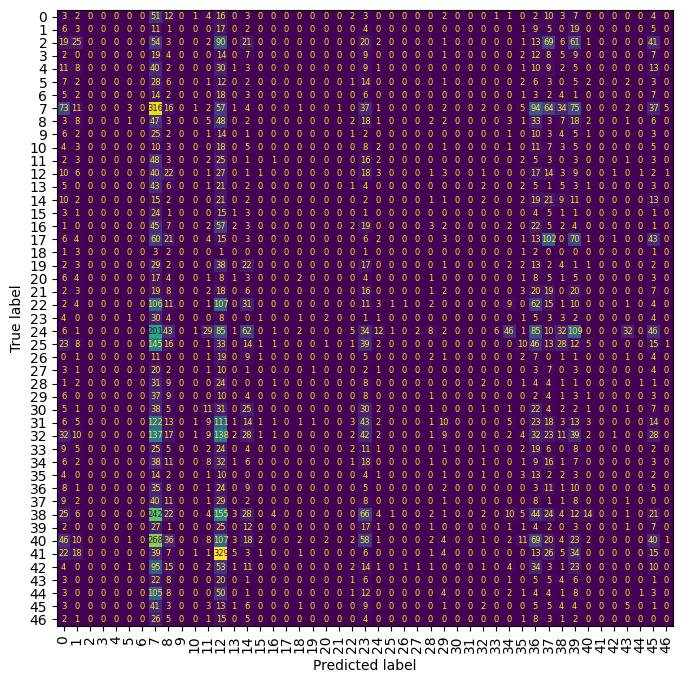

In [35]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
# Criando a exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.rcParams["figure.figsize"] = (10,8)
# Definindo o tamanho da figura
plt.figure(figsize=(10,8))
# Plotando a matriz de confusão com uma escala de cores personalizada
im = disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d', colorbar=False)
# Ajustando o tamanho da fonte manualmente
for text in im.text_.ravel():
    text.set_fontsize(6)
# Exibindo a figura
plt.show()

In [ ]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
# Criando a exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.rcParams["figure.figsize"] = (10,8)
# Definindo o tamanho da figura
plt.figure(figsize=(10, 8))
# Obtendo a imagem da matriz de confusão com uma escala de cores personalizada
im = disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d', colorbar=False)
# Ajustando as cores para a escala logarítmica
im = plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis', norm=LogNorm())
# Adicionando a barra de cores
#plt.colorbar(im)
# Ajustando o tamanho da fonte manualmente
for text in im.axes.texts:
    text.set_fontsize(6)
# Exibindo a figura
plt.show()